# Macaque ex-vivo Experiment

In [1]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt
from matplotlib import gridspec
os.chdir('../')
from src.data_loading import LoadCSV, LoadCSVandVIDEO
from src.data_preprocessing.video import rotate_video, crop_video_depend_scanposition, downsample_video
from dimensionality_reduction import Autoencoder
from timeseries_modeling import Three_Layer_Feedforward_NN_using_ELM as TFNN_ELM

In [2]:
rcParams_dict = {
    'font.family':'Times New Roman',
    'mathtext.fontset':'stix',
    'font.size':15,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'axes.linewidth':1.5,
    'xtick.major.size':8,
    'ytick.major.size':8,}
for key in rcParams_dict.keys():plt.rcParams[str(key)] = rcParams_dict[str(key)]

In [3]:
### DEFINE
SEED = 0
CSV_DIR = './data/macaque_exvivo/CSV/'
AVI_DIR = './data/macaque_exvivo/AVI/'
DATA_NAME = '912'
SAMPLE_SPAN = [65000, 75010]
LINESCAN_PARAM = {'position':[155, 160], 'width':100}
ROTATE_ANGLE = 10
DOWNSAMPLE_FACTOR = 2
N_TRAIN = 4000
N_TEST = 4000
LATENT_SIZE_LIST = [1, 2, 3, 4, 5]
LATENT_SIZE = 3
SCALAR_TRAIN = MinMaxScaler()
SCALAR_TEST = MinMaxScaler()
BRIGHTNESS_CORRECTION = 1.
OUTLIER_CORRECTION = 0#1e-10

In [4]:
### Load data
[], video, video_t = LoadCSVandVIDEO(CSV_DIR+DATA_NAME+".csv", [], SAMPLE_SPAN, AVI_DIR+DATA_NAME+".avi")
### Preprocess
video = rotate_video(video, ROTATE_ANGLE)
video = crop_video_depend_scanposition(video, LINESCAN_PARAM)
video = downsample_video(video, DOWNSAMPLE_FACTOR)
video_shape = video.shape
X, T = (video.reshape(-1, video_shape[1]*video_shape[2])+OUTLIER_CORRECTION)/255., video_t
T -= T[0]
del video, video_t
### Split X into train & test sets
X_train, X_test = X[:N_TRAIN], X[N_TRAIN:N_TRAIN+N_TEST]
T_train, T_test = T[:N_TRAIN], T[N_TRAIN:N_TRAIN+N_TEST]
del X, T
### Scaling
X_train_scaled = SCALAR_TRAIN.fit_transform(X_train.copy())
X_test_scaled = SCALAR_TEST.fit_transform(X_test.copy())

Loading csv data
file path | ./data/macaque_exvivo/CSV/912.csv
data list | 
Loading video data
file path | ./data/macaque_exvivo/AVI/912.avi


In [5]:
### Setting autoencoder
AE_PARAMETERS={"learning_rate": 5e-4,
                "loss_function": "mse",
                "train_size_rate": 0.8,
                "batch_size": 128,
                "epoch": 200,
                "early_stopping": False,
                "early_stopping_round": 10,
                "output_log": False}

### Numerical experiments
loss_valid_list = []
for i, latent_size in enumerate(LATENT_SIZE_LIST):
    print("Experiment"+str(i+1)+" (Latent size: "+str(latent_size)+") ")
    AE_MODEL = Autoencoder(X_train_scaled.shape[1], latent_size, seed=SEED)
    AE_MODEL.fit(X_train_scaled, AE_PARAMETERS)
    loss_valid_list.append(AE_MODEL.loss_valid)
    print("   loss of valid data: "+str(AE_MODEL.loss_valid[-1]))
    del AE_MODEL

Experiment1 (Latent size: 1) 
   loss of valid data: 0.01917148381471634
Experiment2 (Latent size: 2) 
   loss of valid data: 0.012526600621640682
Experiment3 (Latent size: 3) 
   loss of valid data: 0.009966972284018993
Experiment4 (Latent size: 4) 
   loss of valid data: 0.00881990883499384
Experiment5 (Latent size: 5) 
   loss of valid data: 0.007548960391432047


In [6]:
def autoencoder_validloss_list(loss_valid_list, label_list, threshold_value=0.01, 
                             c=('g', 'b', 'r', 'm', 'c'), 
                             ls=((0, (2, 1)), (0, (5, 1)), (0, (8, 1)), (0, (2, 1, 1, 1)), (0, (5, 1, 1, 1))),
                             y_lim=(0, None)) :
    spec = gridspec.GridSpec(ncols=1, nrows=1)
    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot(spec[0])
    ax.axhline(y=threshold_value, linestyle='-', c='k')
    for i in range(len(loss_valid_list)): ax.plot(np.arange(1, len(loss_valid_list[i])+1), loss_valid_list[i], lw=2, c=c[i], linestyle=ls[i], label=label_list[i])
    ax.set_xlabel(r'Epochs')
    ax.set_ylabel(r'Loss of input and output layers')
    ax.set_ylim(y_lim[0], y_lim[1])
    fig.legend(loc="upper center", facecolor="white", edgecolor="white", bbox_to_anchor=(0.5, 1.06), ncol=len(loss_valid_list))
    plt.show()

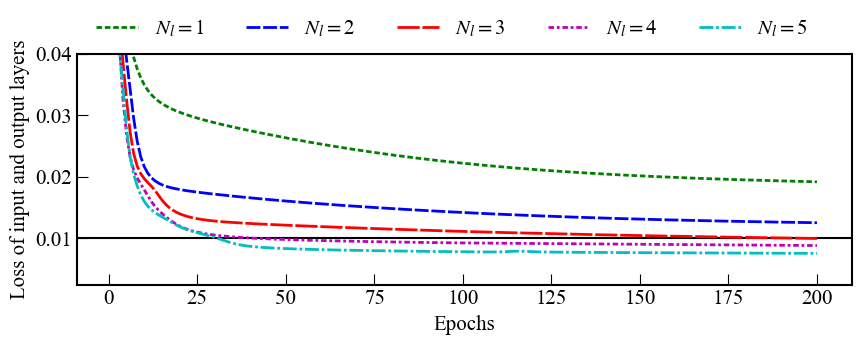

In [15]:
autoencoder_validloss_list(loss_valid_list, 
                           [r"$N_l=$"+str(LATENT_SIZE_LIST[0]),
                            r"$N_l=$"+str(LATENT_SIZE_LIST[1]),
                            r"$N_l=$"+str(LATENT_SIZE_LIST[2]),
                            r"$N_l=$"+str(LATENT_SIZE_LIST[3]),
                            r"$N_l=$"+str(LATENT_SIZE_LIST[4])], 
                            y_lim=(None, 0.05))

In [16]:
### Setting autoencoder
AE_PARAMETERS={"learning_rate": 5e-4,
                "loss_function": "mse",
                "train_size_rate": 0.8,
                "batch_size": 128,
                "epoch": 200,
                "early_stopping": False,
                "early_stopping_round": 10,
                "output_log": True}

### Numerical experiments
AE_MODEL = Autoencoder(X_train_scaled.shape[1], LATENT_SIZE, seed=SEED)
AE_MODEL.fit(X_train_scaled, AE_PARAMETERS)
x_test = AE_MODEL.transform(X_test_scaled)
X_test_hat = SCALAR_TEST.inverse_transform(AE_MODEL.inverse_transform(AE_MODEL.transform(X_test_scaled)))

Epoch 1/200
25/25 [==============================] - 1s 15ms/step - loss: 0.1076 - val_loss: 0.0981
Epoch 2/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0819 - val_loss: 0.0654
Epoch 3/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0543 - val_loss: 0.0463
Epoch 4/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0416 - val_loss: 0.0385
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0349 - val_loss: 0.0325
Epoch 6/200
25/25 [==============================] - 0s 11ms/step - loss: 0.0293 - val_loss: 0.0273
Epoch 7/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0249 - val_loss: 0.0238
Epoch 8/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0222 - val_loss: 0.0217
Epoch 9/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0206 - val_loss: 0.0205
Epoch 10/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0196 - val_loss: 0.0197
Epoc

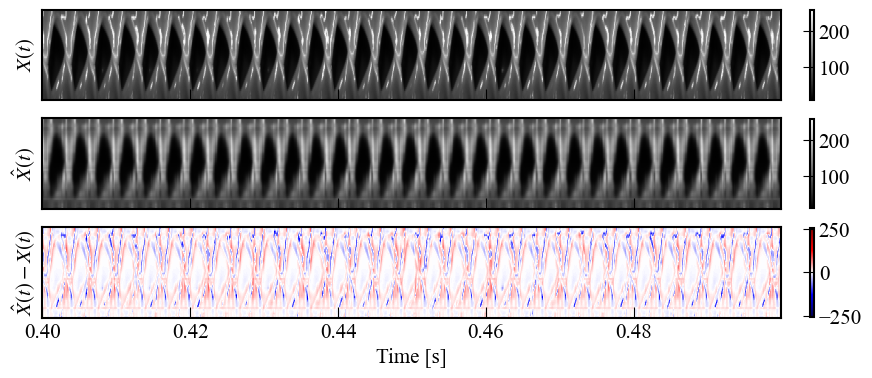

In [17]:
def line_scanning(video, linescan_params):
    position = linescan_params['position']
    width = linescan_params['width']
    return video[:, (position[0]-int(width/2)):(position[0]+int(width/2)), position[1]]

def autoencoder_input_output(X_input, X_output, T, n_plt, linescan_params, video_shape):
    X_input = line_scanning(X_input.reshape(-1, video_shape[1], video_shape[2]), linescan_params)
    X_output = line_scanning(X_output.reshape(-1, video_shape[1], video_shape[2]), linescan_params)
    aspect = n_plt/(X_input.shape[1]*80000)
    t_min = T[0]
    t_max = T[n_plt - 1] if n_plt <= len(T) else T[-1]

    spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[1, 0.04], height_ratios=[1, 1, 1], wspace=0)
    fig = plt.figure(figsize=(10, 4))

    ax = fig.add_subplot(spec[0])
    img = ax.imshow(X_input[:n_plt].T, aspect=aspect, cmap="gray", 
              extent=[t_min, t_max, 1, X_input.shape[1]], 
              vmax=np.max(X_input[:n_plt]), vmin=np.min(X_input[:n_plt]))
    ax.set_ylabel(r'$X(t)$')
    ax.tick_params(labelleft=False, labelbottom=False, left=False)

    ax = fig.add_subplot(spec[1])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    ax = fig.add_subplot(spec[2])
    img = ax.imshow(X_output[:n_plt].T, aspect=aspect, cmap="gray", 
              extent=[t_min, t_max, 1, X_output.shape[1]], 
              vmax=np.max(X_input[:n_plt]), vmin=np.min(X_input[:n_plt]))
    ax.set_ylabel(r'$\hat{X}(t)$')
    ax.tick_params(labelleft=False, labelbottom=False, left=False)

    ax = fig.add_subplot(spec[3])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    ax = fig.add_subplot(spec[4])
    img = ax.imshow((X_output[:n_plt] - X_input[:n_plt]).T, aspect=aspect, cmap="seismic", 
              extent=[t_min, t_max, 1, X_output.shape[1]], 
              vmax=np.max(np.abs(X_input[:n_plt])), vmin=-np.max(np.abs(X_input[:n_plt])))
    ax.set_ylabel(r'$\hat{X}(t)-X(t)$')
    ax.set_xlabel(r'Time [s]')
    ax.tick_params(labelleft=False, left=False)

    ax = fig.add_subplot(spec[5])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    plt.show()

linescan_params = {'position':[video_shape[1]//2, video_shape[1]//2], 'width':video_shape[1]/1}
autoencoder_input_output(X_test*255.*BRIGHTNESS_CORRECTION, X_test_hat*255.*BRIGHTNESS_CORRECTION, T_test, 1000,
                         linescan_params, video_shape, )

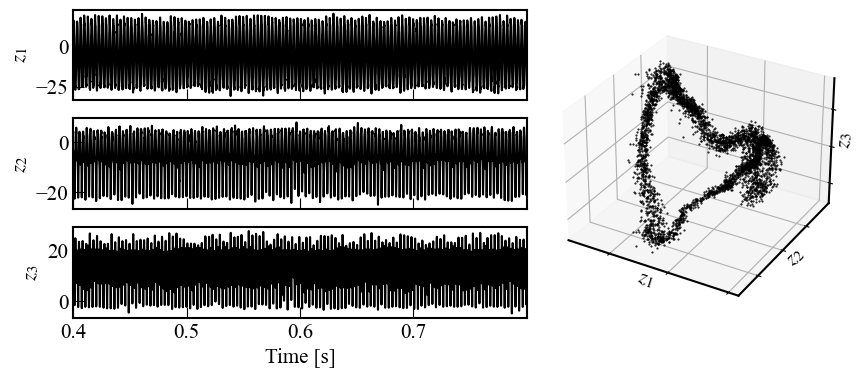

In [18]:
def autoencoder_latent(x, T, n_plt, n_attractor, sort=True):
    if sort: x = x[:, np.argsort(np.var(x, axis=0))[::-1]]
        
    spec = gridspec.GridSpec(ncols=2, nrows=3, height_ratios=[1, 1, 1], width_ratios=[1.5, 1], wspace=0.05)
    fig = plt.figure(figsize=(10, 4))

    ax = fig.add_subplot(spec[0, 0])
    ax.plot(T[:n_plt], x[:, 0][:n_plt], '-', c='k')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z_{1}$')
    ax.tick_params(labelbottom=False)

    ax = fig.add_subplot(spec[1, 0])
    ax.plot(T[:n_plt], x[:, 1][:n_plt], '-', c='k')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z_{2}$')
    ax.tick_params(labelbottom=False)

    ax = fig.add_subplot(spec[2, 0])
    ax.plot(T[:n_plt], x[:, 2][:n_plt], '-', c='k')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z_{3}$')
    ax.set_xlabel(r'Time [s]')

    ax = fig.add_subplot(spec[:, 1], projection='3d')
    ax.plot(x[:n_attractor, 0], x[:n_attractor, 1], x[:n_attractor, 2], '.', ms=1, c='k')
    ax.set_xlabel(r'$z_{1}$', labelpad=-15)
    ax.set_ylabel(r'$z_{2}$', labelpad=-15)
    ax.set_zlabel(r'$z_{3}$', labelpad=-15)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False)
    #ax.set_box_aspect((1,1,1))
    plt.show()

autoencoder_latent(x_test, T_test, 4000, None, sort=True)

In [19]:
def rmse(X, X_hat):
    return np.sqrt(np.sum((X - X_hat)**2, axis=1) / X.shape[1])

def timeseries_modeling(x, x_hat, T, n_plt, rmse_lim=[0, 25], sort=True):
    x_rmse = rmse(x[:n_plt], x_hat[:n_plt])
    if sort:
        x_ = x
        x = x[:, np.argsort(np.var(x_, axis=0))[::-1]]
        x_hat = x_hat[:, np.argsort(np.var(x_, axis=0))[::-1]]

    spec = gridspec.GridSpec(ncols=1, nrows=4, height_ratios=[1, 1, 1, 1])
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(spec[0])
    ax.plot(T[:n_plt], x[:, 0][:n_plt], '-', c='k', label='Exp.')
    ax.plot(T[:n_plt], x_hat[:, 0][:n_plt], '--', c='r', label='Model')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z_{1}$')
    ax.tick_params(labelbottom=False)
    fig.legend(loc="upper center", facecolor="white", edgecolor="white", bbox_to_anchor=(0.5, 0.97), ncol=2)

    ax = fig.add_subplot(spec[1])
    ax.plot(T[:n_plt], x[:, 1][:n_plt], '-', c='k')
    ax.plot(T[:n_plt], x_hat[:, 1][:n_plt], '--', c='r')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z_{2}$')
    ax.tick_params(labelbottom=False)

    ax = fig.add_subplot(spec[2])
    ax.plot(T[:n_plt], x[:, 2][:n_plt], '-', c='k')
    ax.plot(T[:n_plt], x_hat[:, 2][:n_plt], '--', c='r')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z_{3}$')
    ax.tick_params(labelbottom=False)

    ax = fig.add_subplot(spec[3])
    ax.plot(T[:n_plt], x_rmse, lw=1, c='b')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'RMSE')
    ax.set_xlabel(r'Time [s]')
    ax.set_ylim(rmse_lim[0], rmse_lim[-1])

    plt.show()

def timeseries_modeling_3d(x, x_hat, T, n_plt, sort=True):
    if sort:
        x_ = x
        x = x[:, np.argsort(np.var(x_, axis=0))[::-1]]
        x_hat = x_hat[:, np.argsort(np.var(x_, axis=0))[::-1]]

    spec = gridspec.GridSpec(ncols=2, nrows=1, wspace=0.1)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(spec[0], projection='3d')
    ax.set_title('Exp.', loc='center', fontsize=plt.rcParams['font.size'], pad=-5)
    ax.plot(x[:n_plt, 0], x[:n_plt, 1], x[:n_plt, 2], '.', ms=2, c='k')
    ax.set_xlabel(r'$z_{1}$', labelpad=-15)
    ax.set_ylabel(r'$z_{2}$', labelpad=-15)
    ax.set_zlabel(r'$z_{3}$', labelpad=-15)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    #ax.set_box_aspect((1,1,1))

    ax = fig.add_subplot(spec[1], projection='3d')
    ax.set_title('Model', loc='center', fontsize=plt.rcParams['font.size'], pad=-5)
    ax.plot(x_hat[:n_plt, 0], x_hat[:n_plt, 1], x_hat[:n_plt, 2], '.', ms=2, c='r')
    ax.set_xlabel(r'$z_{1}$', labelpad=-15)
    ax.set_ylabel(r'$z_{2}$', labelpad=-15)
    ax.set_zlabel(r'$z _{3}$', labelpad=-15)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    #ax.set_box_aspect((1,1,1))

    plt.show()

def timeseries_modeling_lyaqunov(lyapunov_exponent, x_lim=[0, None], y_lim=[None, None]):
        
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        fig = plt.figure(figsize=(10, 3.5))

        ax = fig.add_subplot(spec[0])
        ax.axhline(y=0, linestyle='--', c='k')
        ax.plot(np.arange(1, lyapunov_exponent.shape[0]+1), lyapunov_exponent, 'o', ms=5, c='b'   )
        ax.set_ylabel(r'Lyapunov enponents')
        ax.set_yscale('symlog', linthresh=1e+1)
        ax.set_xlim(x_lim[0], x_lim[-1])
        ax.set_ylim(y_lim[0], y_lim[-1])
        ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter(r'$\lambda_{%d}$'))

        plt.show()

def timeseries_modeling_image(X, X_hat, T, n_plt, linescan_params, video_shape, rmse_lim=[0, 45]):
    x_rmse = rmse(X[:n_plt], X_hat[:n_plt])
    X = line_scanning(X.reshape(-1, video_shape[1], video_shape[2]), linescan_params)
    X_hat = line_scanning(X_hat.reshape(-1, video_shape[1], video_shape[2]), linescan_params)
    aspect = n_plt/(X.shape[1]*75000)
    t_min = T[0]
    t_max = T[n_plt - 1] if n_plt <= len(T) else T[-1]
    #x_rmse = rmse(X[:n_plt], X_hat[:n_plt])

    spec = gridspec.GridSpec(ncols=2, nrows=4, width_ratios=[1, 0.04], height_ratios=[1, 1, 1, 1], wspace=0)
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(spec[0])
    img = ax.imshow(X[:n_plt].T, aspect=aspect, cmap="gray", 
              extent=[t_min, t_max, 1, X.shape[1]], 
              vmax=255, vmin=0)
    ax.set_ylabel(r'Exp.')
    ax.tick_params(labelleft=False, labelbottom=False, left=False)

    ax = fig.add_subplot(spec[1])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    ax = fig.add_subplot(spec[2])
    img = ax.imshow(X_hat[:n_plt].T, aspect=aspect, cmap="gray", 
              extent=[t_min, t_max, 1, X_hat.shape[1]], 
              vmax=255, vmin=0)
    ax.set_ylabel(r'Model')
    ax.tick_params(labelleft=False, labelbottom=False, left=False)

    ax = fig.add_subplot(spec[3])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    ax = fig.add_subplot(spec[4])
    img = ax.imshow((X_hat[:n_plt] - X[:n_plt]).T, aspect=aspect, cmap="seismic", 
              extent=[t_min, t_max, 1, X_hat.shape[1]], 
              vmax=np.max(np.abs(X[:n_plt])), vmin=-np.max(np.abs(X[:n_plt])))
    ax.set_ylabel(r'Error')
    ax.tick_params(labelleft=False, labelbottom=False, left=False)

    ax = fig.add_subplot(spec[5])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    ax = fig.add_subplot(spec[6])
    ax.plot(T[:n_plt], x_rmse, lw=1, c='b')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'RMSE')
    ax.set_xlabel(r'Time [s]')
    ax.set_ylim(rmse_lim[0], rmse_lim[-1])

    plt.show()

def timeseries_modeling_images(X, X_hat, T, step, video_shape, error_lim=[-100, 100], time_format='{:.3f}'):

    X = X.reshape(-1, video_shape[1], video_shape[2])
    X_hat = X_hat.reshape(-1, video_shape[1], video_shape[2])

    spec = gridspec.GridSpec(ncols=6, nrows=3, wspace=0.1, hspace=0.0 )
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(spec[0])
    idx = step*0
    #ax.set_title('Exp.', loc='left', fontsize=plt.rcParams['font.size'])
    ax.imshow(X[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.set_ylabel('Exp.')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[1])
    idx = step*1
    ax.imshow(X[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[2])
    idx = step*2
    ax.imshow(X[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[3])
    idx = step*3
    ax.imshow(X[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[4])
    idx = step*4
    ax.imshow(X[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[5])
    idx = step*5
    ax.imshow(X[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    
    ax = fig.add_subplot(spec[6])
    idx = step*0
    #ax.set_title('Model', loc='left', fontsize=plt.rcParams['font.size'])
    ax.imshow(X_hat[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.set_ylabel('Model')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[7])
    idx = step*1
    ax.imshow(X_hat[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[8])
    idx = step*2
    ax.imshow(X_hat[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[9])
    idx = step*3
    ax.imshow(X_hat[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[10])
    idx = step*4
    ax.imshow(X_hat[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[11])
    idx = step*5
    ax.imshow(X_hat[idx], cmap='gray', vmax=255, vmin=0)
    #ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[12])
    idx = step*0
    #ax.set_title('Error', loc='left', fontsize=plt.rcParams['font.size'])
    ax.imshow(X[idx]-X_hat[idx], cmap='seismic', vmax=error_lim[-1], vmin=error_lim[0])
    ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.set_ylabel('Error')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[13])
    idx = step*1
    ax.imshow(X[idx]-X_hat[idx], cmap='seismic', vmax=error_lim[-1], vmin=error_lim[0])
    ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[14])
    idx = step*2
    ax.imshow(X[idx]-X_hat[idx], cmap='seismic', vmax=error_lim[-1], vmin=error_lim[0])
    ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[15])
    idx = step*3
    ax.imshow(X[idx]-X_hat[idx], cmap='seismic', vmax=error_lim[-1], vmin=error_lim[0])
    ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[16])
    idx = step*4
    ax.imshow(X[idx]-X_hat[idx], cmap='seismic', vmax=error_lim[-1], vmin=error_lim[0])
    ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax = fig.add_subplot(spec[17])
    idx = step*5
    ax.imshow(X[idx]-X_hat[idx], cmap='seismic', vmax=error_lim[-1], vmin=error_lim[0])
    ax.set_xlabel(str(time_format.format(T[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    plt.show()

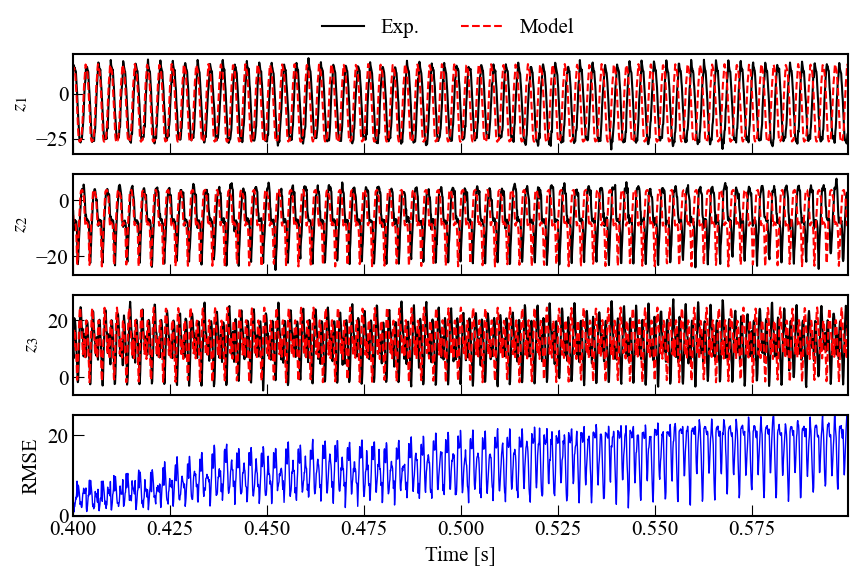

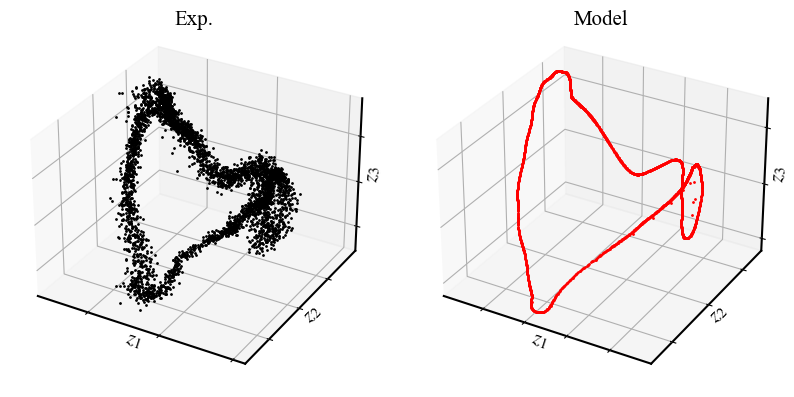

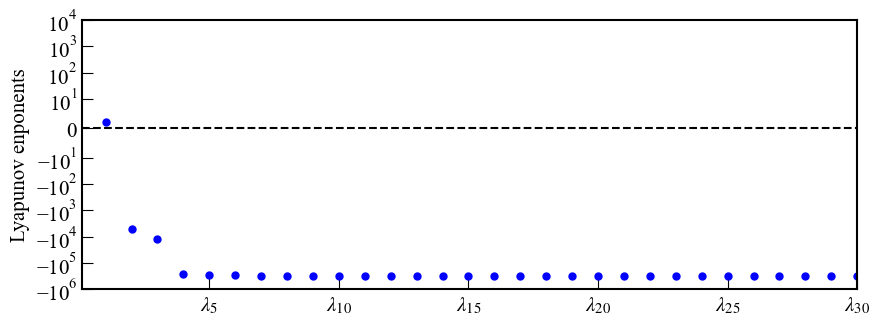

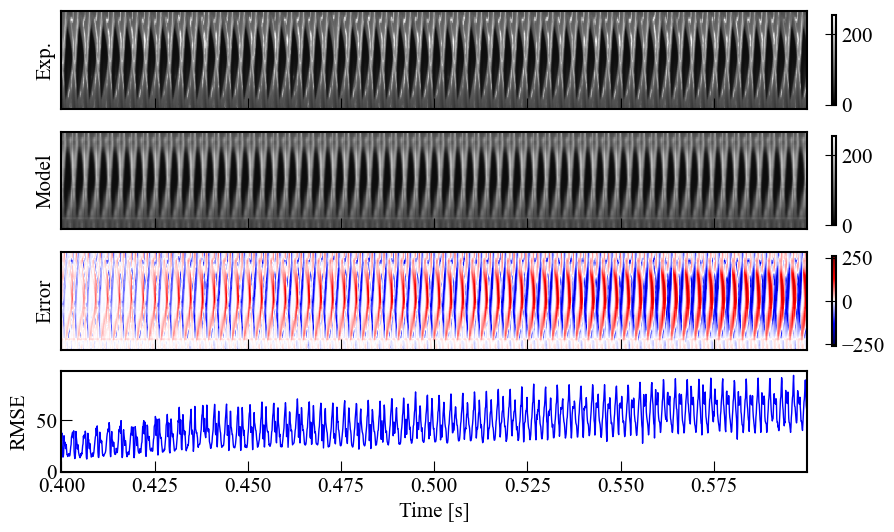

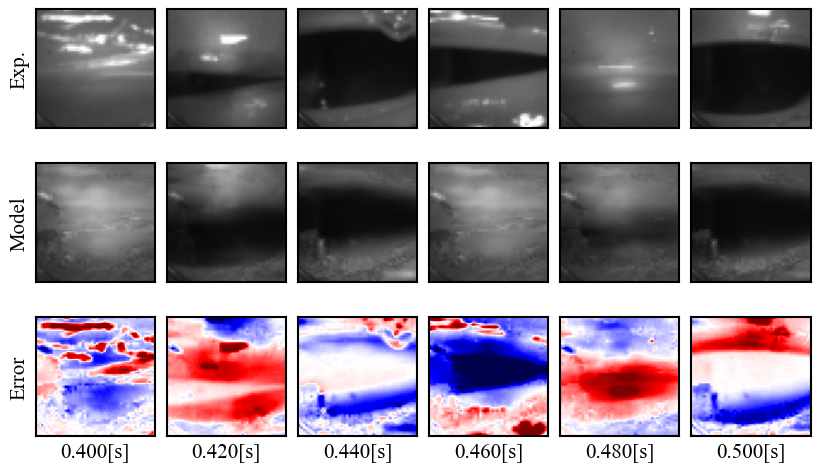

In [52]:
### Setting ELM
HIDDEN_SIZE = 200
INPUT_W_SCALE = 0.1
ACTIVE_FUNC = "tanh"
RIDGE_PARAM = 1e-4
RUN_SIZE = 2000
DT = T_test[1] - T_test[0]

### Timeseries modeling
x_train = AE_MODEL.transform(X_train_scaled)
FNN_MODEL = TFNN_ELM(x_train.shape[1], HIDDEN_SIZE, x_train.shape[1],
                     INPUT_W_SCALE, ACTIVE_FUNC, SEED)
FNN_MODEL.fit(x_train[:-1], x_train[1:], RIDGE_PARAM)
x_test_hat = FNN_MODEL.freerun(x_train[-1], RUN_SIZE)
timeseries_modeling(x_test, x_test_hat, T_test, 2000, sort=True)
timeseries_modeling_3d(x_test, x_test_hat, T_test, None, sort=True)

### Lyaqunov caluculation
lyapunov_exponent = FNN_MODEL.lyapunov_calculation(x_train[-1], RUN_SIZE, DT)
timeseries_modeling_lyaqunov(lyapunov_exponent[:], [0.1, 30], [-1e+6, 1e+4])

### Reconstruct video
X_test_hat = SCALAR_TEST.inverse_transform(AE_MODEL.inverse_transform(x_test_hat))
timeseries_modeling_image(X_test*255.*BRIGHTNESS_CORRECTION, X_test_hat*255*BRIGHTNESS_CORRECTION, T_test, 2000, linescan_params, video_shape, [0, None])
timeseries_modeling_images(X_test*255.*BRIGHTNESS_CORRECTION, X_test_hat*255*BRIGHTNESS_CORRECTION, T_test, 200, video_shape, )

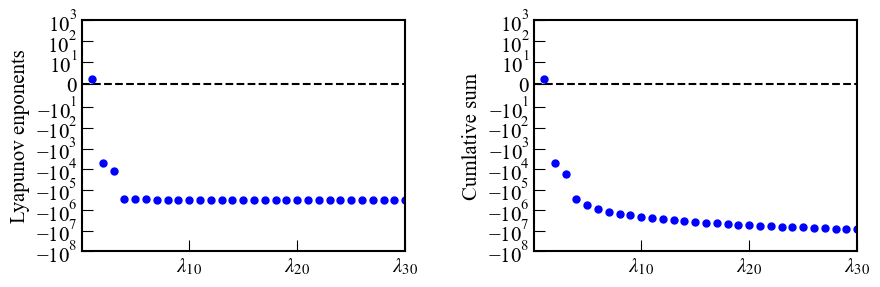

In [60]:
def timeseries_modeling_lyaqunov_cumsum(lyapunov_exponent, x_lim=[0, None], y_lim=[None, None], y_cumsum=[None, None]):
        
        spec = gridspec.GridSpec(ncols=2, nrows=1, wspace=0.4)
        fig = plt.figure(figsize=(10, 3))

        ax = fig.add_subplot(spec[0])
        ax.axhline(y=0, linestyle='--', c='k')
        ax.plot(np.arange(1, lyapunov_exponent.shape[0]+1), lyapunov_exponent, 'o', ms=5, c='b'   )
        ax.set_ylabel(r'Lyapunov enponents')
        ax.set_yscale('symlog', linthresh=1e+1)
        ax.set_xlim(x_lim[0], x_lim[-1])
        ax.set_ylim(y_lim[0], y_lim[-1])
        ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter(r'$\lambda_{%d}$'))

        ax = fig.add_subplot(spec[1])
        #fractal_dimension = np.argmin(np.where(np.cumsum(lyapunov_exponent)>0, np.cumsum(lyapunov_exponent), 0))
        #ax.axvline(x=fractal_dimension, linestyle='--', c='k')
        ax.axhline(y=0, linestyle='--', c='k')
        #ax.text(fractal_dimension, np.cumsum(lyapunov_exponent)[-1], r'$D_{\lambda}$', fontsize=plt.rcParams['font.size'])
        ax.plot(np.arange(1, lyapunov_exponent.shape[0]+1), np.cumsum(lyapunov_exponent), 'o', ms=5, c='b'   )
        ax.set_ylabel(r'Cumlative sum')
        ax.set_yscale('symlog', linthresh=1e+1)
        ax.set_xlim(x_lim[0], x_lim[-1])
        ax.set_ylim(y_cumsum[0], y_cumsum[-1])
        ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter(r'$\lambda_{%d}$'))

        plt.show()

timeseries_modeling_lyaqunov_cumsum(lyapunov_exponent[:], [0.1, 30], [-1e+8, 1e+3], [-1e+8, 1e+3])